In [116]:
import pandas as pd
import numpy as np
import itertools


from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, jaccard_score, hamming_loss, log_loss

from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

import warnings
warnings.filterwarnings("ignore")

In [53]:
# use custom function to get the corpus df, label dfs, and validation dfs
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [54]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)

In [55]:
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,two hussein ally hang iraqi official say
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [57]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


## Prepare Multilabel Classification Evaluation

In [7]:
def evaluate_multilabel_classification(lst, df, RNN=False):
    plt.figure(figsize=(15,20))
    subplot_num = 1

    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        
        plt.subplot(3,2,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        accuracy = tp/(fp + tn + tp)
        precision = tp/(fp + tp)
        recall = tp/(tp + fn)
        f1 = 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn))))
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn)))))
        print('\n')

        

## One Versus Rest Model

In [23]:
X_train, X_test, y_train, y_test = train_test_split(corpus_df['text'], emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], random_state=3)


In [9]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_test


<313x2332 sparse matrix of type '<class 'numpy.float64'>'
	with 1138 stored elements in Compressed Sparse Row format>

In [24]:
lr = LogisticRegression(C=1e10, class_weight='balanced')
knn = KNeighborsClassifier()
rf = RandomForestClassifier(max_depth=12, class_weight='balanced')

ovr = OneVsRestClassifier(rf)

ovr.fit(tf_idf_X_train, y_train)
ovr_train_preds = ovr.predict(tf_idf_X_train)
ovr_test_preds = ovr.predict(tf_idf_X_test)

In [25]:
ovr_preds_df = pd.DataFrame(ovr_test_preds, columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
ovr_preds_df = pd.concat([ovr_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.35648148148148145
anger_label precision: 0.8850574712643678
anger_label recall 0.4425287356321839
anger_label f1 0.5900383141762452


disgust_label accuracy: 0.22272727272727272
disgust_label precision: 0.7101449275362319
disgust_label recall 0.34507042253521125
disgust_label f1 0.4644549763033175


fear_label accuracy: 0.47368421052631576
fear_label precision: 0.9
fear_label recall 0.4225352112676056
fear_label f1 0.5750798722044729


joy_label accuracy: 0.5683453237410072
joy_label precision: 0.6723404255319149
joy_label recall 0.8186528497409327
joy_label f1 0.7383177570093458


sadness_label accuracy: 0.697986577181208
sadness_label precision: 0.7675276752767528
sadness_label recall 0.9327354260089686
sadness_label f1 0.8421052631578948


surprise_label accuracy: 0.8964401294498382
surprise_label precision: 0.8964401294498382
surprise_label recall 0.9857651245551602
surprise_label f1 0.9389830508474577




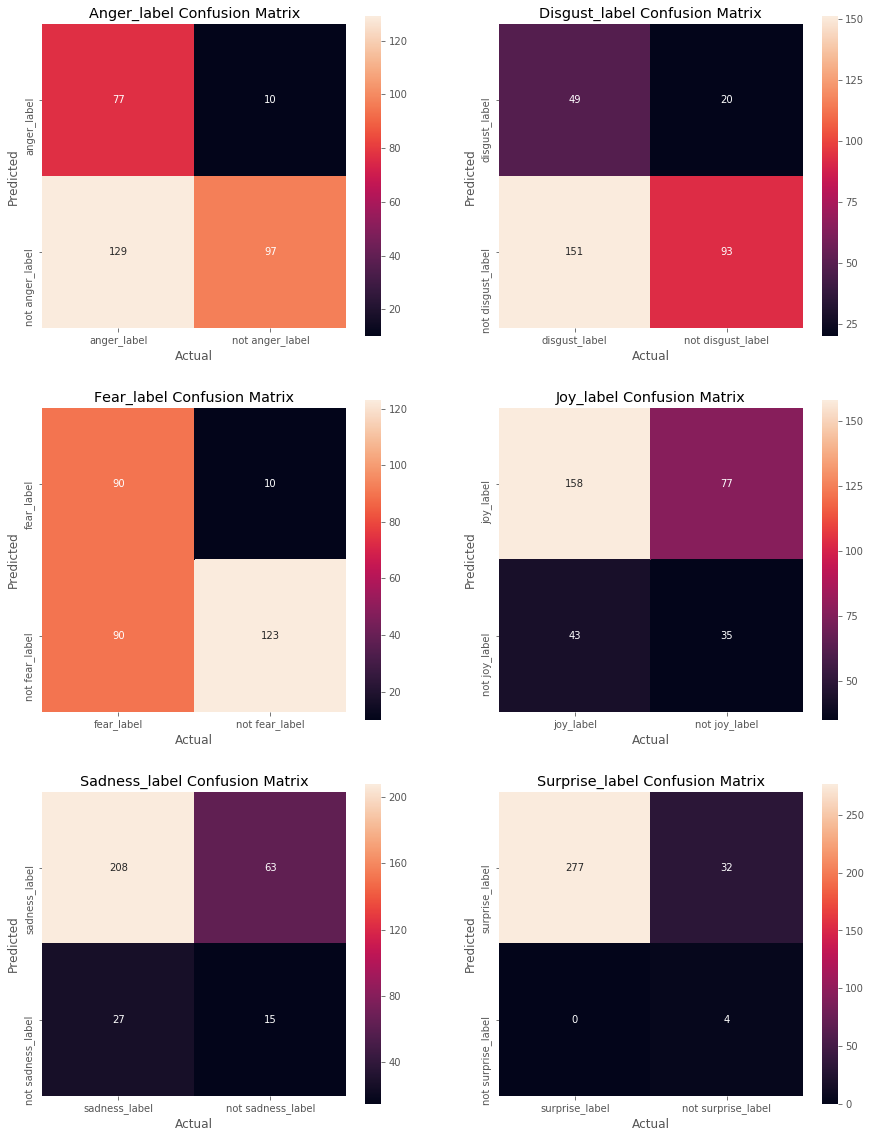

In [26]:
evaluate_multilabel_classification(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], ovr_preds_df)


In [27]:
jaccard_score_samples = jaccard_score(y_test, ovr_test_preds, average='samples')
jaccard_score_weighted = jaccard_score(y_test, ovr_test_preds, average='weighted')
hamming_loss_score = hamming_loss(y_test, ovr_test_preds)
f1_macro_score = f1_score(y_test, ovr_test_preds, average='macro')
log_loss_score = log_loss(y_test, ovr_test_preds)
print('jaccard score:', jaccard_score_samples )
print('hamming loss:', hamming_loss_score)
print('f1 macro:', f1_macro_score)
print('log loss', log_loss_score)

jaccard score: 0.6153887113951012
hamming loss: 0.3083067092651757
f1 macro: 0.691496538949789
log loss 45.307913220258456


## Classifier Chain

In [28]:
np.random.seed=42
perms = list(itertools.permutations([0,1,2,3,4,5]))
random = np.random.choice(len(perms), size=720,)
perms_to_try = [perms[i] for i in random]

chains = [ClassifierChain(rf, order=perms_to_try[i]) for i in range(720)]

results_jaccard = []
preds = []
for chain in chains:
    chain.fit(tf_idf_X_train, y_train)
    test_preds = chain.predict(tf_idf_X_test)
    preds.append(test_preds)
    results_jaccard.append(jaccard_score(y_test, test_preds, average='samples'))


In [29]:
cc_test_preds = preds[results_jaccard.index(max(results_jaccard))]
max(results_jaccard)

0.6285942492012779

In [30]:
cc_preds_df = pd.DataFrame(cc_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
#y _reindex = y_test.reset_index(drop=True)
cc_preds_df = pd.concat([cc_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.5366666666666666
anger_label precision: 0.5985130111524164
anger_label recall 0.9252873563218391
anger_label f1 0.7268623024830699


disgust_label accuracy: 0.4143835616438356
disgust_label precision: 0.5
disgust_label recall 0.852112676056338
disgust_label f1 0.6302083333333334


fear_label accuracy: 0.6240601503759399
fear_label precision: 0.7477477477477478
fear_label recall 0.7793427230046949
fear_label f1 0.7632183908045977


joy_label accuracy: 0.375
joy_label precision: 0.8181818181818182
joy_label recall 0.37305699481865284
joy_label f1 0.5124555160142348


sadness_label accuracy: 0.6928327645051194
sadness_label precision: 0.7748091603053435
sadness_label recall 0.9103139013452914
sadness_label f1 0.8371134020618557


surprise_label accuracy: 0.8904109589041096
surprise_label precision: 0.8996539792387543
surprise_label recall 0.9252669039145908
surprise_label f1 0.9122807017543859




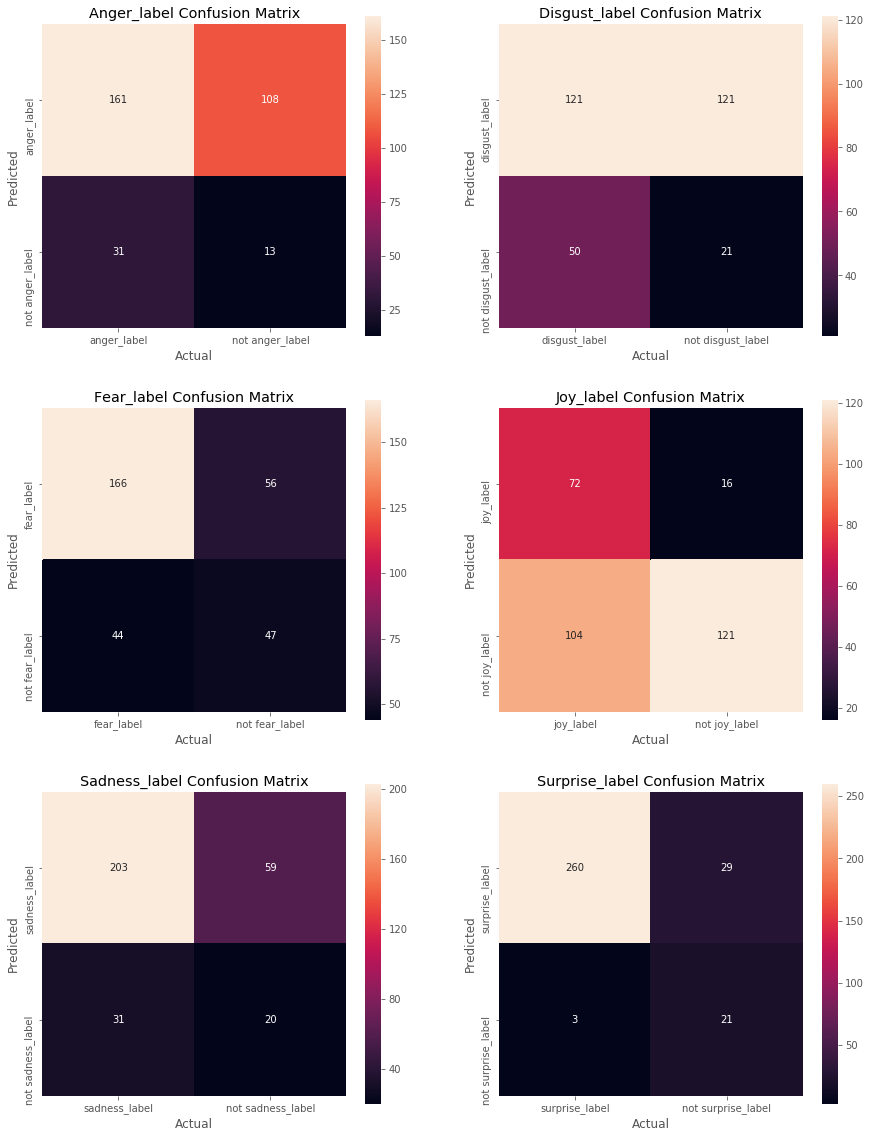

In [31]:
evaluate_multilabel_classification(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], cc_preds_df)



In [32]:
jaccard_score_samples = jaccard_score(y_test, cc_test_preds.toarray(), average='samples')
jaccard_score_weighted = jaccard_score(y_test, cc_test_preds.toarray(), average='weighted')
hamming_loss_score = hamming_loss(y_test, cc_test_preds.toarray())
f1_macro_score = f1_score(y_test, cc_test_preds.toarray(), average='macro')
log_loss_score = log_loss(y_test, cc_test_preds.toarray())
print('jaccard score average:', jaccard_score_samples )
print('jaccard score weighted:', jaccard_score_weighted )
print('hamming loss:', hamming_loss_score)
print('f1 macro:', f1_macro_score)
print('log loss', log_loss_score)

jaccard score average: 0.6285942492012779
jaccard score weighted: 0.6189293879444008
hamming loss: 0.3365282215122471
f1 macro: 0.7303564410752462
log loss 32.53879137892777


## Label Power Emotion Labels

In [33]:
lp = LabelPowerset(rf)

lp.fit(tf_idf_X_train, y_train)
lp_train_preds = lp.predict(tf_idf_X_train)
lp_test_preds = lp.predict(tf_idf_X_test)

In [34]:
LP_preds_df = pd.DataFrame(lp_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
LP_preds_df = pd.concat([LP_preds_df, y_reindex], axis=1)


In [35]:
LP_preds_df.head()

,pred_anger_label,pred_disgust_label,pred_fear_label,pred_joy_label,pred_sadness_label,pred_surprise_label,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,0,0,1,1,0,0,1,1,1,1
1,0,0,0,0,1,1,0,0,1,1,1,1
2,0,0,0,0,1,1,0,0,1,0,1,1
3,1,1,0,1,0,1,0,1,1,0,0,1
4,1,1,0,1,1,1,1,1,1,1,1,1


anger_label accuracy: 0.22777777777777777
anger_label precision: 0.7592592592592593
anger_label recall 0.23563218390804597
anger_label f1 0.3596491228070175


disgust_label accuracy: 0.1895734597156398
disgust_label precision: 0.6666666666666666
disgust_label recall 0.28169014084507044
disgust_label f1 0.39603960396039606


fear_label accuracy: 0.2805755395683453
fear_label precision: 0.7358490566037735
fear_label recall 0.18309859154929578
fear_label f1 0.2932330827067669


joy_label accuracy: 0.21568627450980393
joy_label precision: 0.7857142857142857
joy_label recall 0.17098445595854922
joy_label f1 0.2808510638297872


sadness_label accuracy: 0.7019867549668874
sadness_label precision: 0.726027397260274
sadness_label recall 0.9506726457399103
sadness_label f1 0.8233009708737864


surprise_label accuracy: 0.889273356401384
surprise_label precision: 0.8954703832752613
surprise_label recall 0.9145907473309609
surprise_label f1 0.9049295774647886




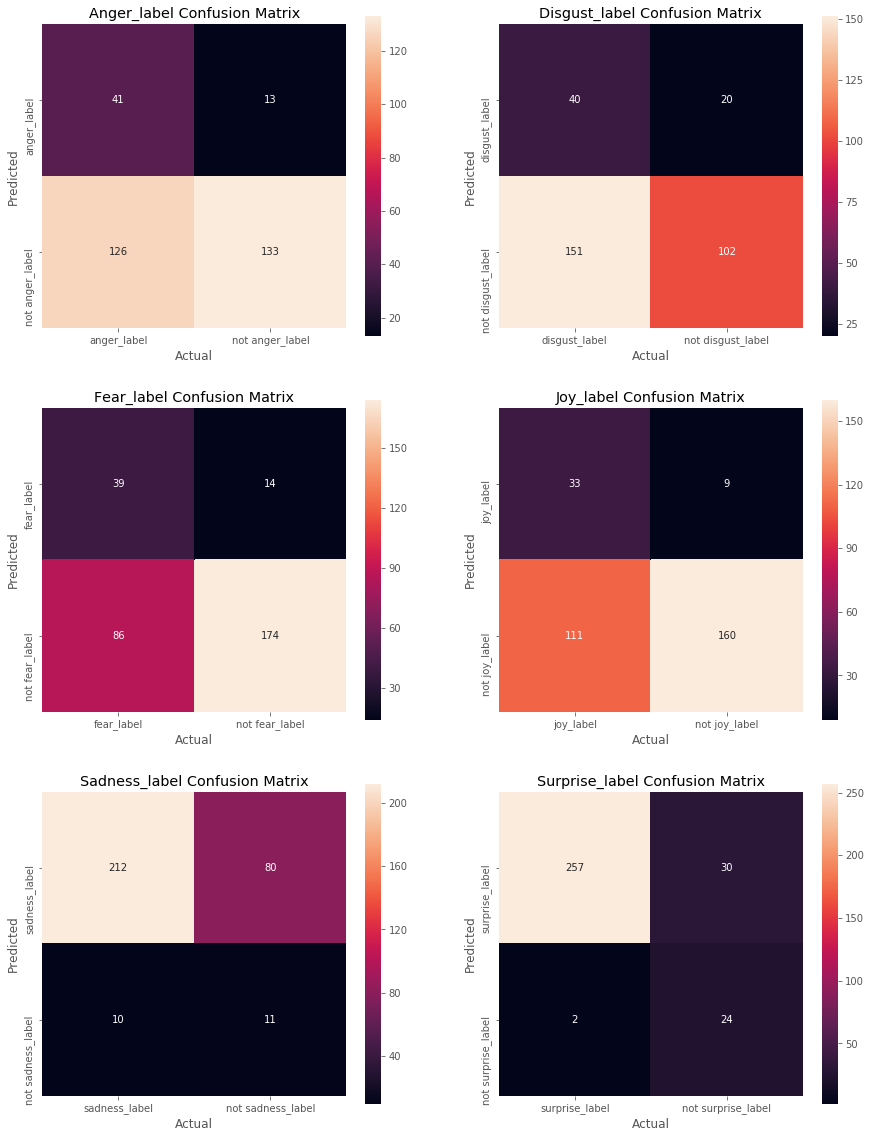

In [36]:
evaluate_multilabel_classification(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], LP_preds_df)


In [37]:
jaccard_score_samples = jaccard_score(y_test, lp_test_preds.toarray(), average='samples')
jaccard_score_weighted = jaccard_score(y_test, lp_test_preds.toarray(), average='weighted')
hamming_loss_score = hamming_loss(y_test, lp_test_preds.toarray())
f1_macro_score = f1_score(y_test, lp_test_preds.toarray(), average='macro')
log_loss_score = log_loss(y_test, lp_test_preds.toarray())
print('jaccard score average:', jaccard_score_samples )
print('jaccard score weighted:', jaccard_score_weighted )
print('hamming loss:', hamming_loss_score)
print('f1 macro:', f1_macro_score)
print('log loss:', log_loss_score)

jaccard score average: 0.44605963791267306
jaccard score weighted: 0.43195047593618713
hamming loss: 0.410010649627263
f1 macro: 0.5096672369404237
log loss: 69.65670346834865


## RNN for Multilabel Classification

In [58]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)
            

In [102]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(corpus_df['text']))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=15, padding='post')
padded_X

array([[  32,  643,  153, ...,    0,    0,    0],
       [  39,  644,  298, ...,    0,    0,    0],
       [ 645, 1081, 1082, ...,    0,    0,    0],
       ...,
       [ 641,  419,  125, ...,    0,    0,    0],
       [  42,  637, 2776, ...,    0,    0,    0],
       [ 118,  332,    0, ...,    0,    0,    0]], dtype=int32)

In [103]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]
        

In [104]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], test_size=0.25, random_state=2)

# labels multihot encoded
y_train_multihot = y_train.values
y_test_multihot = y_test.values


In [105]:
X_train.shape

(937, 15)

In [129]:
model = Sequential()

callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), 
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=15, trainable=False))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(BatchNormalization())

# model.add(Dropout(0.5))

model.add(LSTM(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train_multihot,
                    epochs=30,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0: 3, 1: 1}, {0: 4, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
                    validation_data=(X_test, y_test_multihot))

Train on 937 samples, validate on 313 samples
Epoch 1/30
937/937 [==============================] - 12s 13ms/step - loss: 0.6691 - acc: 0.6521 - val_loss: 0.6454 - val_acc: 0.6858
Epoch 2/30
937/937 [==============================] - 1s 852us/step - loss: 0.5171 - acc: 0.7668 - val_loss: 0.6316 - val_acc: 0.7050
Epoch 3/30
937/937 [==============================] - 1s 860us/step - loss: 0.4426 - acc: 0.8083 - val_loss: 0.5676 - val_acc: 0.7497
Epoch 4/30
937/937 [==============================] - 1s 860us/step - loss: 0.3868 - acc: 0.8428 - val_loss: 0.5764 - val_acc: 0.7375
Epoch 5/30
937/937 [==============================] - 1s 875us/step - loss: 0.3282 - acc: 0.8716 - val_loss: 0.5975 - val_acc: 0.7439
Epoch 6/30
937/937 [==============================] - 1s 877us/step - loss: 0.2729 - acc: 0.8997 - val_loss: 0.6309 - val_acc: 0.7497
Epoch 7/30
937/937 [==============================] - 1s 843us/step - loss: 0.2300 - acc: 0.9233 - val_loss: 0.5888 - val_acc: 0.7556
Epoch 8/30
937/9

313/313 [==============================] - 0s 347us/step


[0.5437029232613195, 0.7587859480144878]

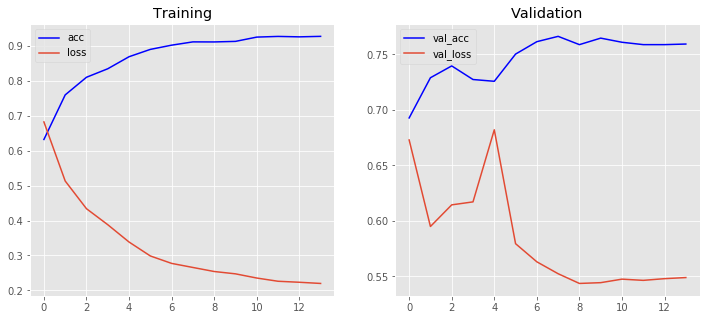

In [127]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')
plt.title("Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.title("Validation")
plt.legend()

model.evaluate(X_test, y_test_multihot)


In [47]:
# model.save('RNN_multiclass_emotion.h5')

RNN_preds = model.predict_on_batch(X_test)

RNN_preds_df = pd.DataFrame({"pred_anger":RNN_preds[:,0], "pred_disgust":RNN_preds[:,1], "pred_fear":RNN_preds[:,2], "pred_joy":RNN_preds[:,3], "pred_sadness":RNN_preds[:,4], "pred_surprise":RNN_preds[:,5], "anger":y_test_multihot[:,0], "disgust":y_test_multihot[:,1], "fear": y_test_multihot[:,2], "joy": y_test_multihot[:,3], "sadness": y_test_multihot[:,4], "surprise": y_test_multihot[:,5]})


anger accuracy: 0.4404332129963899
anger precision: 0.7721518987341772
anger recall 0.7721518987341772
anger f1 0.7721518987341772


disgust accuracy: 0.3204225352112676
disgust precision: 0.6363636363636364
disgust recall 0.7583333333333333
disgust f1 0.6920152091254753


fear accuracy: 0.6063829787234043
fear precision: 0.7737556561085973
fear recall 0.8465346534653465
fear f1 0.8085106382978723


joy accuracy: 0.5680933852140078
joy precision: 0.8156424581005587
joy recall 0.7227722772277227
joy f1 0.7664041994750658


sadness accuracy: 0.6123188405797102
sadness precision: 0.8125
sadness recall 0.8203883495145631
sadness f1 0.8164251207729469


surprise accuracy: 0.8767605633802817
surprise precision: 0.9021739130434783
surprise recall 0.89568345323741
surprise f1 0.8989169675090252




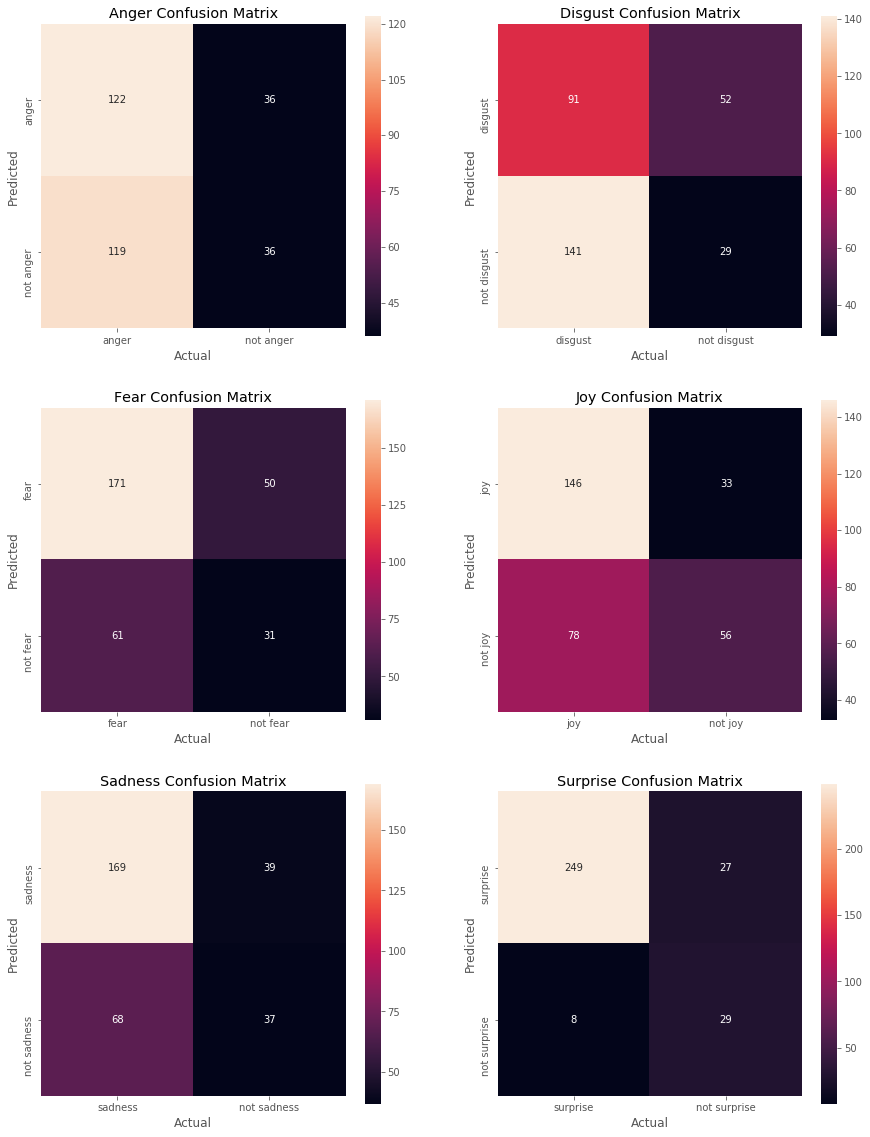

In [48]:
evaluate_multilabel_classification(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'], RNN_preds_df, RNN=True)

In [52]:
jaccard_score_samples = jaccard_score(y_test, RNN_preds>.5, average='samples')
jaccard_score_weighted = jaccard_score(y_test, RNN_preds>.5, average='weighted')
hamming_loss_score = hamming_loss(y_test, RNN_preds>.5)
f1_macro_score = f1_score(y_test, RNN_preds>.5, average='macro')
log_loss_score = log_loss(y_test, RNN_preds>.5)
print('jaccard score average:', jaccard_score_samples )
print('jaccard score weighted:', jaccard_score_weighted )
print('hamming loss:', hamming_loss_score)
print('f1 macro:', f1_macro_score)
print('log loss:', log_loss_score)

jaccard score average: 0.6919062832800852
jaccard score weighted: 0.6813669245111486
hamming loss: 0.2422790202342918
f1 macro: 0.7924040056524272
log loss: 28.234306754153195
